
## <center>Aarushi Kalaimani, Ananta Ramesh, Laxmi Sindhu Samudrala, Sainath Reddy Vuppaluru
## <center>DATA 245
## <center> December 14, 2020
## <center> Group 7 - Report


### **What is the problem that we are trying to solve?**

### *Motivation for the project*

Kickstarter is an American corporation that runs a global crowdfunding platform. Its mission is to help creators bring their projects to life by connecting them with interested backers. The model used by Kickstarter is similar to the patronage that kings and other noblemen offered artists back in the olden days.

The way Kickstarter works is a creator creates a campaign by giving it a title, a description, a goal amount, and a deadline date. If they are able to get enough backers to meet their goal amount by their deadline, their campaign is a success and they receive their funding. If they are unable to meet their goal, the campaign is considered a failure and they receive no money.

With this sort of business model in place, it is very lucrative for campaign creators to get insight on whether their venture will succeed or fail before the deadline date. This will allow them to maximize their chances of succeeding by ramping up on publicity and offering freebies and other such crowdpleasers. This is the motivation for our project - determining what features affect a campaign's success more than others, and ultimately using that information to provide feedback to campaign creators at the start of their launch.

When you download Kickstarter campaigns' data, there are several pieces of information you obtain - the category of the campaign, the name and description of the campaign (created by its creator), the country of origin of the campaign, the dates of creation, launch, and end of the campaign respectively, the goal amount of the campaign, among various others.

Our goal is to use only the information that is available at the start of the campaign, i.e. the information provided by the artist, to predict success/failure of the campaign.

### **How to approach this problem**

We are approaching this problem like a supervised machine learning problem. We have various descriptive features that we will use to build our model. Some of the categorical features we are planning to use include the country of origin of the campaign, the category of the campaign, etc. Some of the numerical features we are planning to use include the goal amount of the campaign. We are also planning to make use of the launch and deadline dates of the campaign, and the name and description of the campaign. 

We need to determine which among these features are most correlated with our target variable (the state of the campaign - 1 for successful and 0 for failed). We will then convert those features into a usable format, either by log transforming them or by encoding them numerically, and create a model which will use those features to predict the value of the state variable.

The benchmark we are using is the accuracy of a model that simply predicts the majority class for all the rows - this is the accuracy we aim to beat.

### **Data Source**

The dataset is obtained from the following website - https://webrobots.io/kickstarter-datasets/ in csv format.

### **Data Characteristics and Preprocessing**

The Kickstarter dataset is originally composed of 38 attributes, which describe each Kickstarter project in terms of factors such as how the project is categorized, the status of the project (e.g. successful, failed, live, or canceled), the targeted goal for funding, the project launch date, the project deadline, whether the project is highlighted on Kickstarter’s website, etc. The attributes are of various data types, including datetime, float, and string (or categorical) objects.
 
The web scraping tool linked above looks up Kickstarter projects from 2009 to 2020 and generates sixty csv files which are then loaded into a pandas dataframe. The dataframe originally consists of 219,688 values; however, a look-up for duplicated instances by project ID leads us to drop 27,669 values from the dataframe. Furthermore, a search for null values across leads us to drop the following attributes from further analysis, since more than 30% values are missing: friends, is_backing, is_starred, and permissions. We also drop a subset of columns that we believe do not provide supporting information to improve classification of projects by status:  creator, currency, currency_symbol, currency_trailing_code, fx_rate, disable_communication, id, location_json, photo, profile, slug, source_url, and usd_type.

Given that Kickstarter is supported in multiple countries across the world, quantities for crowdfunding goals are provided in country-specific currencies, as well as the currencies as USD (U.S. dollar) conversions. To simplify analysis, we choose to only consider the U.S. dollar-based conversions of all project monetary data. Also, we observe that the datetime attributes in this dataset are provided as Unix time stamps, hence data processing includes the conversion of all datetime variables to standard timestamps.

We observe that the ‘category’ attribute follows a JSON format and contains additional details of value to our analysis, including the project’s main category (e.g. Film and Video), and sub-category (e.g. Drama).  In addition to extracting the main and sub-category names from the ‘category’ attribute, data cleaning concludes with the exclusion of projects that are of ‘live’ or ‘cancelled’ status, narrowing our analysis to only projects that are classified as ‘successful’ or ‘failed’.

Exploration of the cleaned dataset reveals that 55% of the projects are successful, 40% are failed, and 5% are cancelled. Analyzing the datetime attributes reveals that most projects last for 30-40 days, covering the project launch date to the project deadline. We also observe that most projects are launched in 2015, with projects launched in 2016-2020 far outnumbering projects from 2009-2014. This  speaks to Kickstarter’s increased popularity after a few years following the company’s launch. Further data exploration highlights are provided as commentary throughout the source code.


## Importing Libraries

In [1]:
import glob
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Cleaning

#### Loading data to a dataframe

In [3]:
# df = pd.concat([pd.read_csv(file) for file in glob.glob('/content/drive/Shared drives/ML project/Kickstarter data/data/Kickstarter*.csv')], ignore_index = True)
df = pd.concat([pd.read_csv(file) for file in glob.glob('Kickstarter*.csv')], ignore_index = True)

In [4]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type'],
      dtype='object')

In [5]:
pd.set_option('display.max_columns',100)
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,61,Support great art! Join us as we re-stage the ...,"{""id"":254,""name"":""Performances"",""slug"":""dance/...",4618,US,the United States,1579292017,"{""id"":2092817311,""name"":""Brooklyn Ballet"",""slu...",USD,$,True,USD,1583025192,False,NaN,1.0,3000.0,1568973024,NaN,False,NaN,1580433192,"{""id"":12589335,""name"":""Brooklyn"",""slug"":""brook...",Revisionist History 2,NaN,"{""key"":""assets/027/785/229/436e3e732fb36a494fe...",4618.0,"{""id"":3914215,""project_id"":3914215,""state"":""in...",revisionist-history-2,https://www.kickstarter.com/discover/categorie...,True,True,successful,1583025192,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",4618.0,domestic
1,52,JinBucha is a new kind of Brewery in North Par...,"{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",3461,US,the United States,1446051515,"{""id"":1468694331,""name"":""Jing Chen"",""slug"":""ji...",USD,$,True,USD,1450118057,False,NaN,1.0,20000.0,1782378629,NaN,False,NaN,1447526057,"{""id"":2487889,""name"":""San Diego"",""slug"":""san-d...",JinBucha: A Modern Kombucha tasting room in No...,NaN,"{""key"":""assets/012/291/675/7fb6348cc8cb988e243...",3461.0,"{""id"":2198010,""project_id"":2198010,""state"":""in...",jinbucha-a-modern-kombucha-tasting-room-in-nor...,https://www.kickstarter.com/discover/categorie...,False,True,failed,1450118057,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",3461.0,domestic
2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...","{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",0,US,the United States,1518159717,"{""id"":2026565095,""name"":""Giovanni"",""is_registe...",USD,$,True,USD,1520233260,False,NaN,1.0,15000.0,2076142479,NaN,False,NaN,1518208887,"{""id"":2442047,""name"":""Los Angeles"",""slug"":""los...",Tea Room Cafe - Daily & Herb Tea,NaN,"{""key"":""assets/020/178/062/a5fae29636630f332e0...",0.0,"{""id"":3304826,""project_id"":3304826,""state"":""in...",tea-room-cafe-daily-and-herb-tea,https://www.kickstarter.com/discover/categorie...,False,False,failed,1520233260,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,domestic
3,2,Bringing Philly cheesesteaks (and other delici...,"{""id"":311,""name"":""Food Trucks"",""slug"":""food/fo...",25,US,the United States,1454217596,"{""id"":1629155736,""name"":""Glenn Edwards"",""is_re...",USD,$,True,USD,1459885844,False,NaN,1.0,2000.0,1416797221,NaN,False,NaN,1454705444,"{""id"":2391279,""name"":""Denver"",""slug"":""denver-c...",HELP TWO BROTHERS OPEN A FOOD TRUCK!,NaN,"{""key"":""assets/012/368/128/1784842b814ce9a6660...",25.0,"{""id"":2349147,""project_id"":2349147,""state"":""in...",help-two-brothers-open-a-food-truck,https://www.kickstarter.com/discover/categorie...,False,False,failed,1459885844,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",25.0,domestic
4,150,a frog plushie keychain and frog butt pin for ...,"{""id"":28,""name"":""Product Design"",""slug"":""desig...",3275,US,the United States,1571342290,"{""id"":932326000,""name"":""rainylune"",""slug"":""rai...",USD,$,True,USD,1574445600,False,NaN,1.0,800.0,1708708142,NaN,False,NaN,1573236000,"{""id"":2474209,""name"":""Pleasanton"",""slug"":""plea...",Son the Frog Plushie Keychain + JUICY Pin,NaN,"{""key"":""assets/027/120/236/7d088ddbc3b3f156741...",3275.0,"{""id"":3834865,""project_id"":3834865,""state"":""ac...",son-the-frog-plushie-keychain-juicy-pin,https://www.kickstarter.com/discover/categorie...,True,False,successful,1574445600,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",3275.0,domestic


In [6]:
df.shape

(219688, 38)

In [7]:
x = len(df[df.duplicated(subset='id')])
print(f'There are {x} duplicated instances in the dateset')

There are 27669 duplicated instances in the dateset


#### Droping 27669 duplicated instances from the dataset

In [8]:
df.drop_duplicates(subset = 'id',keep = 'first',inplace = True)
df.reset_index(drop = True) 

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,61,Support great art! Join us as we re-stage the ...,"{""id"":254,""name"":""Performances"",""slug"":""dance/...",4618,US,the United States,1579292017,"{""id"":2092817311,""name"":""Brooklyn Ballet"",""slu...",USD,$,True,USD,1583025192,False,NaN,1.000000,3000.0,1568973024,NaN,False,NaN,1580433192,"{""id"":12589335,""name"":""Brooklyn"",""slug"":""brook...",Revisionist History 2,NaN,"{""key"":""assets/027/785/229/436e3e732fb36a494fe...",4618.00,"{""id"":3914215,""project_id"":3914215,""state"":""in...",revisionist-history-2,https://www.kickstarter.com/discover/categorie...,True,True,successful,1583025192,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",4618.000000,domestic
1,52,JinBucha is a new kind of Brewery in North Par...,"{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",3461,US,the United States,1446051515,"{""id"":1468694331,""name"":""Jing Chen"",""slug"":""ji...",USD,$,True,USD,1450118057,False,NaN,1.000000,20000.0,1782378629,NaN,False,NaN,1447526057,"{""id"":2487889,""name"":""San Diego"",""slug"":""san-d...",JinBucha: A Modern Kombucha tasting room in No...,NaN,"{""key"":""assets/012/291/675/7fb6348cc8cb988e243...",3461.00,"{""id"":2198010,""project_id"":2198010,""state"":""in...",jinbucha-a-modern-kombucha-tasting-room-in-nor...,https://www.kickstarter.com/discover/categorie...,False,True,failed,1450118057,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3461.000000,domestic
2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...","{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",0,US,the United States,1518159717,"{""id"":2026565095,""name"":""Giovanni"",""is_registe...",USD,$,True,USD,1520233260,False,NaN,1.000000,15000.0,2076142479,NaN,False,NaN,1518208887,"{""id"":2442047,""name"":""Los Angeles"",""slug"":""los...",Tea Room Cafe - Daily & Herb Tea,NaN,"{""key"":""assets/020/178/062/a5fae29636630f332e0...",0.00,"{""id"":3304826,""project_id"":3304826,""state"":""in...",tea-room-cafe-daily-and-herb-tea,https://www.kickstarter.com/discover/categorie...,False,False,failed,1520233260,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,domestic
3,2,Bringing Philly cheesesteaks (and other delici...,"{""id"":311,""name"":""Food Trucks"",""slug"":""food/fo...",25,US,the United States,1454217596,"{""id"":1629155736,""name"":""Glenn Edwards"",""is_re...",USD,$,True,USD,1459885844,False,NaN,1.000000,2000.0,1416797221,NaN,False,NaN,1454705444,"{""id"":2391279,""name"":""Denver"",""slug"":""denver-c...",HELP TWO BROTHERS OPEN A FOOD TRUCK!,NaN,"{""key"":""assets/012/368/128/1784842b814ce9a6660...",25.00,"{""id"":2349147,""project_id"":2349147,""state"":""in...",help-two-brothers-open-a-food-truck,https://www.kickstarter.com/discover/categorie...,False,False,failed,1459885844,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",25.000000,domestic
4,150,a frog plushie keychain and frog butt pin for ...,"{""id"":28,""name"":""Product Design"",""slug"":""desig...",3275,US,the United States,1571342290,"{""id"":932326000,""name"":""rainylune"",""slug"":""rai...",USD,$,True,USD,1574445600,False,NaN,1.000000,800.0,1708708142,NaN,False,NaN,1573236000,"{""id"":2474209,""name"":""Pleasanton"",""slug"":""plea...",Son the Frog Plushie Keychain + JUICY Pin,NaN,"{""key"":""assets/027/120/236/7d088ddbc3b3f156741...",3275.00,"{""id"":3834865,""project_id"":3834865,""state"":""ac...",son-the-frog-plushie-keychain-juicy-pin,https://www.kickstarter.com/discover/categorie...,True,False,successful,1574445600,1.000000,"{""web"":{""project

In [9]:
df.shape

(192019, 38)

In [10]:
df.isnull().sum()

backers_count                    0
blurb                            8
category                         0
converted_pledged_amount         0
country                          0
country_displayable_name         0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
friends                     191932
fx_rate                          0
goal                             0
id                               0
is_backing                  191932
is_starrable                     0
is_starred                  191932
launched_at                      0
location                       213
name                             0
permissions                 191932
photo                            0
pledged                          0
profile                          0
slug                

#### Droping columns and nan values
#### 1.) There are around 99.8% missing values for friends, is_backing, is_starred, permissions and friends columns. Hence, dropping those columns
#### 2.) Removing the rows for 8 projects for which there is no project name.
#### 3.) Also, dropping creator, currency, currency_symbol, currency_trailing_code, fx_rate, disable_communication, id, location_json, photo, profile, slug, source_url, usd_type columns because those columns are not having much information to do analysis

In [11]:
df.drop(['is_backing','current_currency','is_starred','permissions','friends','creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'disable_communication', 'id', 'fx_rate', 'photo', 'profile', 'urls','slug', 'country_displayable_name','location','source_url', 'usd_type'], axis = 1, inplace = True)

In [12]:
df = df[df['blurb'].notna()]
df.reset_index(drop= True,inplace = True)
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,deadline,goal,is_starrable,launched_at,name,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged
0,61,Support great art! Join us as we re-stage the ...,"{""id"":254,""name"":""Performances"",""slug"":""dance/...",4618,US,1579292017,1583025192,3000.0,False,1580433192,Revisionist History 2,4618.0,True,True,successful,1583025192,1.0,4618.0
1,52,JinBucha is a new kind of Brewery in North Par...,"{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",3461,US,1446051515,1450118057,20000.0,False,1447526057,JinBucha: A Modern Kombucha tasting room in No...,3461.0,False,True,failed,1450118057,1.0,3461.0
2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...","{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",0,US,1518159717,1520233260,15000.0,False,1518208887,Tea Room Cafe - Daily & Herb Tea,0.0,False,False,failed,1520233260,1.0,0.0
3,2,Bringing Philly cheesesteaks (and other delici...,"{""id"":311,""name"":""Food Trucks"",""slug"":""food/fo...",25,US,1454217596,1459885844,2000.0,False,1454705444,HELP TWO BROTHERS OPEN A FOOD TRUCK!,25.0,False,False,failed,1459885844,1.0,25.0
4,150,a frog plushie keychain and frog butt pin for ...,"{""id"":28,""name"":""Product Design"",""slug"":""desig...",3275,US,1571342290,1574445600,800.0,False,1573236000,Son the Frog Plushie Keychain + JUICY Pin,3275.0,True,False,successful,1574445600,1.0,3275.0


#### Representing the goal amount in the USD currency format

In [13]:
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'], 2)

#### Converting the Unix time stamp to standard timestamp

In [14]:
df['created_at'] = pd.to_datetime(df['created_at'], unit='s')
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')
df['state_changed_at'] = pd.to_datetime(df['state_changed_at'], unit='s')

In [15]:
df['launch_to_deadline'] = df['deadline'] - df['launched_at']
df['launch_to_deadline'] = df['launch_to_deadline'].dt.round('d').dt.days

df['creation_to_launch'] = df['launched_at'] - df['created_at']
df['creation_to_launch'] = df['creation_to_launch'].dt.round('d').dt.days

df['launch_year'] = df['launched_at'].dt.year
df['launch_month'] = df['launched_at'].dt.month

df['deadline_year'] = df['launched_at'].dt.year
df['deadline_month'] = df['deadline'].dt.month

#### Extracting the main_category column

In [16]:
json_list = []    # Extracting the sub-category names of the projects
for i in range(len(df)):
    json_list.append(json.loads(df['category'][i]))

# json_list[0]['parent_name']

category = []
for i in range(len(json_list)):
    category.append(json_list[i]['name'])

df.rename(columns={'category':'category_json', 'location': 'location_json'}, inplace=True)

df['category'] = category # Adding sub-category name column as category to the dataframe

main_category = []   # Extracting the main-category names of the projects
for i in range(len(json_list)):
    main_category.append(json_list[i].get('parent_name', 'None'))

df['main_category'] = main_category  # Adding main-category name column as main-category to the dataframe

df.drop(['category_json'], axis=1, inplace=True)
df.reset_index(inplace = True)
for i in range(0,len(df)):
    if df.loc[i,'main_category']=='None':
        df.loc[i,'main_category'] = df.loc[i,'category']

#### Exculding the live and cancelled projects for the analysis

In [17]:
df = df[(df['state'] != 'live') & (df['state'] !='canceled')]
viz_df = df.copy()

# Data Exploration

Out of all projects in kickstarters around 55% of projects were successful, 40% of projects failed and remaining 5% projects were cancelled

<AxesSubplot:xlabel='state'>

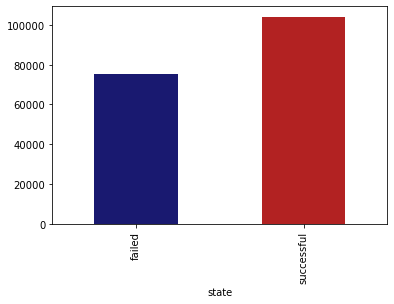

In [18]:
viz_df.groupby('state').staff_pick.count().plot(kind = 'bar', color = ['midnightblue','firebrick'])

#### Examining dates of creation, launch, and deadline of campaigns

#### Comparing campaign creation and launch dates

<AxesSubplot:xlabel='creation_to_launch', ylabel='Count'>

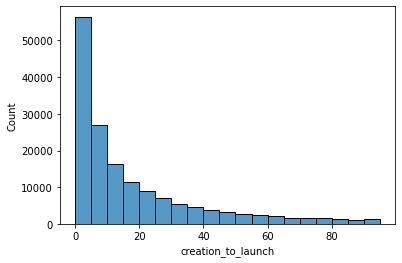

In [19]:
bins = [_*5 for _ in range(0,20)]
sns.histplot(viz_df['creation_to_launch'], bins = bins )

We see that, most of the time, creating and launching a kickstarter campaign happens on the same day! The distribution is basically an exponential one that approaches 0 as the number of days increases.

#### Examining how many days are present, on average, between a campaign launch and its deadline

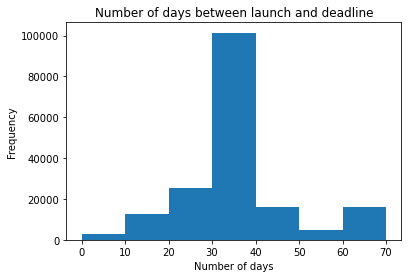

In [20]:
plt.title('Number of days between launch and deadline')
plt.hist(viz_df['launch_to_deadline'], bins = [0,10,20,30,40,50,60,70])
plt.xlabel('Number of days');
plt.ylabel('Frequency');

We see that, on average, most campaigns have a month (between 30 and 40 days) between when they launch and when they set their deadline. This allows for momentum to be maintained and for people to bid immediately rather than losing steam.

#### Examining campaign launch dates

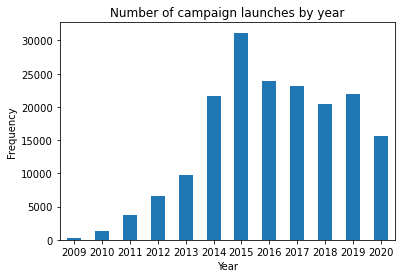

In [21]:
plt.title('Number of campaign launches by year')
viz_df['launch_year'].value_counts(sort=False).plot(kind='bar', rot=0);
plt.xlabel('Year');
plt.ylabel('Frequency');

We see that 2015 saw the greatest number of Kickstarter campaigns being launched. The number of campaigns launched from 2016-2020 outnumbers the number of campaigns from 2009-2014. This makes sense because Kickstarter began only in 2009 and needed a few years to become popular and establish itself as a good medium to use for crowdsourcing.

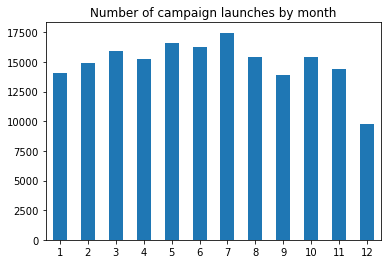

In [22]:
plt.title('Number of campaign launches by month')
viz_df['launch_month'].value_counts(sort=False).plot(kind='bar',rot=0);

We see that July sees the greatest number of launches and December sees the fewest. Overall, several months have >15000 launches.


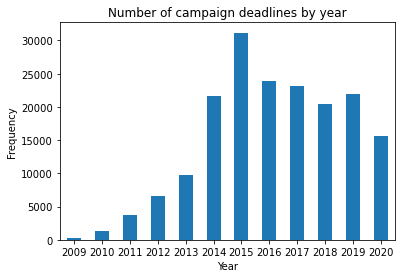

In [23]:
plt.title('Number of campaign deadlines by year')
viz_df['deadline_year'].value_counts(sort=False).plot(kind='bar', rot=0);
plt.xlabel('Year');
plt.ylabel('Frequency');

We see that the maximum number of campaign deadlines was in 2015. This makes sense since we know that the maximum number of launches was in 2015 and the average period of time between a campaign launch and its deadline is between 30 and 40 days.

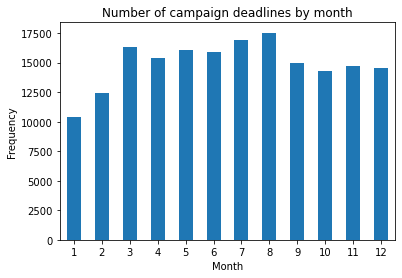

In [24]:
plt.title('Number of campaign deadlines by month')
viz_df['deadline_month'].value_counts(sort=False).plot(kind='bar', rot=0);
plt.xlabel('Month');
plt.ylabel('Frequency');

The maximum number of campaign deadlines is in August. We can use the same logic as above to understand it - most campaign begin in July and since they take around 30 days on average to end, we can foresee that most campaigns will end in August.

#### Staff Picked projects Exploratory Analysis

If a project is picked by staff, there is only around 10% chance of failure of the project whereas, there is almost 45% chance of failure

The average no of backers for staff picked projects are almost 8 times high when compared to the projects not picked by staff

The median goal and pledged amount for staff picked projects are around 10,000 USD

(0.0, 12000.0)

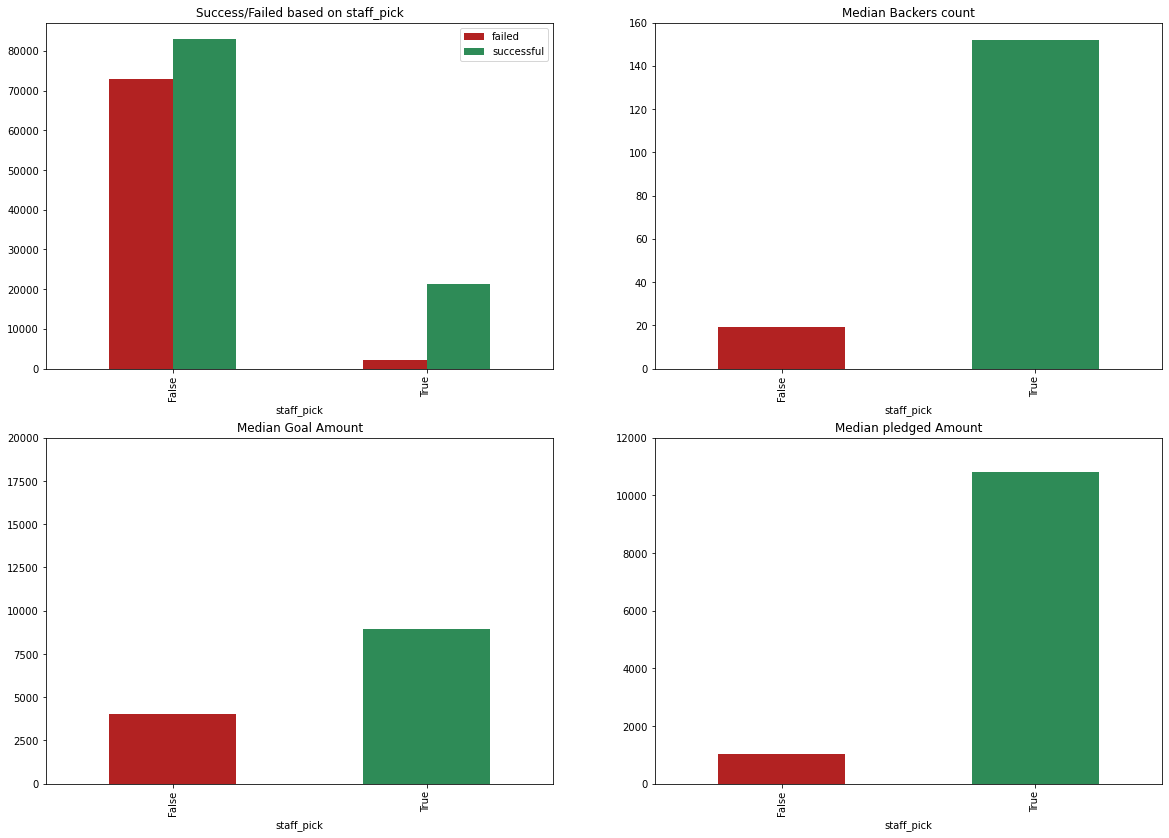

In [25]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20,14))
pick_df = pd.get_dummies(viz_df.set_index('staff_pick').state).groupby('staff_pick').sum()
pick_df.plot(kind = 'bar', ax = ax1, color=['firebrick', 'seagreen'])
ax1.set_title('Success/Failed based on staff_pick')

viz_df.groupby('staff_pick').backers_count.median().plot(kind = 'bar', ax = ax2, color = ['firebrick', 'seagreen'])
ax2.set_title('Median Backers count')
ax2.set_ylim(0,160)

viz_df.groupby('staff_pick').usd_goal.median().plot(kind = 'bar', ax = ax3, color = ['firebrick', 'seagreen'])
ax3.set_title('Median Goal Amount')
ax3.set_ylim(0,20000)

viz_df.groupby('staff_pick').usd_pledged.median().plot(kind = 'bar', ax = ax4, color = ['firebrick', 'seagreen'])
ax4.set_title('Median pledged Amount')
ax4.set_ylim(0,12000)

Generating word cloud based for blurb

In [26]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

In [27]:
text = " ".join(desc for desc in viz_df.blurb)

In [28]:
stopwords = set(STOPWORDS)
stopwords.add('want')
stopwords.add('will')
stopwords.add('made')
stopwords.add('need')

Word Cloud of blurb for all projects


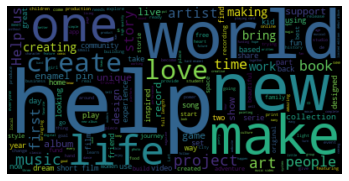

In [29]:
print("Word Cloud of blurb for all projects")
wordcloud = WordCloud(stopwords=stopwords).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
success = " ".join(desc for desc in viz_df[viz_df["state"]=='successful'].blurb)
fail = " ".join(desc for desc in viz_df[viz_df["state"]=='failed'].blurb)

Word cloud of blurb for successful projects


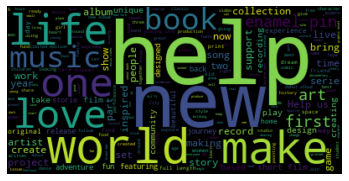

In [31]:
print("Word cloud of blurb for successful projects")
wordcloud = WordCloud(stopwords=stopwords).generate(success)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Word cloud of blurb for failed projects


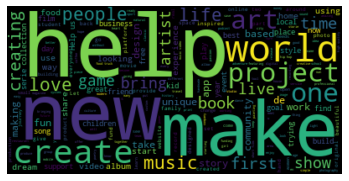

In [32]:
print("Word cloud of blurb for failed projects")
wordcloud = WordCloud(stopwords=stopwords).generate(fail)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [33]:
# df.drop(columns=['level_0','index','backers_count', 'converted_pledged_amount', 'country_displayable_name','current_currency', 'goal', 'pledged', 'state_changed_at','static_usd_rate','urls','usd_pledged'],inplace = True)

**NLP on Blurb**

Objective: to use natural language processing to analyze the project blurb descriptions, here using TextBlob and SentimentIntensityAnalyzer from the NLTK package

In [34]:
from textblob import TextBlob
import nltk

In [35]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saina\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


New columns are created to store the sentiment polarity, sentiment subjectivity, length, and sentiment intensity score for each project description/blurb, using TextBlob as well as SentimentIntensityAnalyzer from the NLTK package.

In [36]:
df.reset_index(drop = True, inplace = True)
df['polarity'] = 0.0
df['subjectivity'] = 0.0
df['blurb_length'] = 0
df['sentiment_intensity'] = 0.0

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

* Combining Project name and blurb cloumns into a single column to do sentimental analysis.
* Removing stopwords and puntuations.
* Finding Polarity, Subjectivity, sentement intensity for each project.

In [38]:
from nltk.corpus import stopwords
import re
import string
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
stop = set(stopwords.words('english'))
for i in range(len(df)):
    blurb = df['name'][i]+df['blurb'][i]
    blurb = blurb.lower()
    blurb = remove_stopwords(blurb)
    blurb = re.sub('\[.*?\]', '', blurb)
    blurb = re.sub('[%s]' % re.escape(string.punctuation), '', blurb)
    blurb = re.sub('\w*\d\w*', '', blurb)
    blurb = re.sub('[‘’“”…]', '', blurb)
    if isinstance(blurb, str) :
        blob = TextBlob(blurb)
        df.loc[i,'polarity'] = blob.sentiment.polarity
        df.loc[i,'subjectivity'] = blob.sentiment.subjectivity
        df.loc[i,'blurb_length'] = len(blurb)
        df.loc[i,'sentiment_intensity'] = sid.polarity_scores(blurb)['compound']

In [39]:
df.to_pickle("df_pickle.pkl") # Converting to pickle format

In [41]:
df = pd.read_pickle("df_pickle.pkl")

In [42]:
df.head()

,index,backers_count,blurb,converted_pledged_amount,country,created_at,deadline,goal,is_starrable,launched_at,name,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_goal,launch_to_deadline,creation_to_launch,launch_year,launch_month,deadline_year,deadline_month,category,main_category,polarity,subjectivity,blurb_length,sentiment_intensity
0,0,61,Support great art! Join us as we re-stage the ...,4618,US,2020-01-17 20:13:37,2020-03-01 01:13:12,3000.0,False,2020-01-31 01:13:12,Revisionist History 2,4618.0,True,True,successful,2020-03-01 01:13:12,1.0,4618.0,3000.0,30,13,2020,1,2020,3,Performances,Dance,0.650000,0.625000,95,0.7430
1,1,52,JinBucha is a new kind of Brewery in North Par...,3461,US,2015-10-28 16:58:35,2015-12-14 18:34:17,20000.0,False,2015-11-14 18:34:17,JinBucha: A Modern Kombucha tasting room in No...,3461.0,False,True,failed,2015-12-14 18:34:17,1.0,3461.0,20000.0,30,17,2015,11,2015,12,Drinks,Food,0.272727,0.450758,158,0.5267
2,2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...",0,US,2018-02-09 07:01:57,2018-03-05 07:01:00,15000.0,False,2018-02-09 20:41:27,Tea Room Cafe - Daily & Herb Tea,0.0,False,False,failed,2018-03-05 07:01:00,1.0,0.0,15000.0,23,1,2018,2,2018,3,Drinks,Food,0.300000,0.475000,98,0.0000
3,3,2,Bringing Philly cheesesteaks (and other delici...,25,US,2016-01-31 05:19:56,2016-04-05 19:50:44,2000.0,False,2016-02-05 20:50:44,HELP TWO BROTHERS OPEN A FOOD TRUCK!,25.0,False,False,failed,2016-04-05 19:50:44,1.0,25.0,2000.0,60,6,2016,2,2016,4,Food Trucks,Food,0.309091,0.600000,117,0.7506
4,4,150,a frog plushie keychain and frog butt pin for ...,3275,US,2019-10-17 19:58:10,2019-11-22 18:00:00,800.0,False,2019-11-08 18:00:00,Son the Frog Plushie Keychain + JUICY Pin,3275.0,True,False,successful,2019-11-22 18:00:00,1.0,3275.0,800.0,14,22,2019,11,2019,11,Product Design,Design,-0.050000,0.150000,94,-0.2023


In [43]:
from sklearn.preprocessing import MinMaxScaler
def preprocessing (df):
    df.drop(columns= ['backers_count','blurb','converted_pledged_amount','created_at','deadline_year','launch_year','deadline','goal','is_starrable','launched_at','name','pledged','spotlight','staff_pick','state_changed_at','static_usd_rate','usd_pledged'],axis = 1,inplace = True)
    df['launch_qtr'] = pd.cut(df['launch_month'], bins=[0,3,6,9,12], labels=['Q1', 'Q2', 'Q3', 'Q4']) # binning the months to Q1, Q2, Q3, Q4
    df['deadline_qtr'] = pd.cut(df['deadline_month'], bins=[0,3,6,9,12], labels=['Q1', 'Q2', 'Q3', 'Q4']) # binning the months to Q1, Q2, Q3, Q4
    df = pd.get_dummies(df,columns = ['launch_qtr','deadline_qtr'], drop_first = True) 
    # Frequency encoding for country and main category features
    country_map = df['country'].value_counts().to_dict()
    mc_map = df['main_category'].value_counts().to_dict()
    df['encoded_country'] = df['country'].map(country_map)
    df['encoded_main_cat'] = df['main_category'].map(mc_map)
    df['encoded_country'] = df['encoded_country']/len(df)
    df['encoded_main_cat'] = df['encoded_main_cat']/len(df)
    # Encoding launch_to_deadline and creation_to_launch features
    ld_map = df['launch_to_deadline'].value_counts().to_dict()
    lc_map = df['creation_to_launch'].value_counts().to_dict()
    df['encode_launch_deadline'] = df['launch_to_deadline'].map(ld_map)
    df['encoded_creation_launch'] = df['creation_to_launch'].map(lc_map)
    df['encode_launch_deadline'] = df['encode_launch_deadline']/len(df)
    df['encoded_creation_launch'] = df['encoded_creation_launch']/len(df)
    # Scaling the usd_goal feature using min-max scaler
    min_ = df['usd_goal'].min()
    max_ = df['usd_goal'].max()
    df['scaled_used_goal'] = df['usd_goal'].map(lambda x: (x-min_)/(max_- min_))
    df.drop(columns=['usd_goal','launch_to_deadline','creation_to_launch','country','category','launch_month','deadline_month','main_category'],axis = 1, inplace = True)
    return df

In [44]:
df.drop(columns = ['index'], axis = 1,inplace = True)
df.reset_index(drop = True,inplace = True)
df['state'].replace({'failed': 0, 'successful': 1},inplace = True)

In [45]:
df.head()

,backers_count,blurb,converted_pledged_amount,country,created_at,deadline,goal,is_starrable,launched_at,name,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_goal,launch_to_deadline,creation_to_launch,launch_year,launch_month,deadline_year,deadline_month,category,main_category,polarity,subjectivity,blurb_length,sentiment_intensity
0,61,Support great art! Join us as we re-stage the ...,4618,US,2020-01-17 20:13:37,2020-03-01 01:13:12,3000.0,False,2020-01-31 01:13:12,Revisionist History 2,4618.0,True,True,1,2020-03-01 01:13:12,1.0,4618.0,3000.0,30,13,2020,1,2020,3,Performances,Dance,0.650000,0.625000,95,0.7430
1,52,JinBucha is a new kind of Brewery in North Par...,3461,US,2015-10-28 16:58:35,2015-12-14 18:34:17,20000.0,False,2015-11-14 18:34:17,JinBucha: A Modern Kombucha tasting room in No...,3461.0,False,True,0,2015-12-14 18:34:17,1.0,3461.0,20000.0,30,17,2015,11,2015,12,Drinks,Food,0.272727,0.450758,158,0.5267
2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...",0,US,2018-02-09 07:01:57,2018-03-05 07:01:00,15000.0,False,2018-02-09 20:41:27,Tea Room Cafe - Daily & Herb Tea,0.0,False,False,0,2018-03-05 07:01:00,1.0,0.0,15000.0,23,1,2018,2,2018,3,Drinks,Food,0.300000,0.475000,98,0.0000
3,2,Bringing Philly cheesesteaks (and other delici...,25,US,2016-01-31 05:19:56,2016-04-05 19:50:44,2000.0,False,2016-02-05 20:50:44,HELP TWO BROTHERS OPEN A FOOD TRUCK!,25.0,False,False,0,2016-04-05 19:50:44,1.0,25.0,2000.0,60,6,2016,2,2016,4,Food Trucks,Food,0.309091,0.600000,117,0.7506
4,150,a frog plushie keychain and frog butt pin for ...,3275,US,2019-10-17 19:58:10,2019-11-22 18:00:00,800.0,False,2019-11-08 18:00:00,Son the Frog Plushie Keychain + JUICY Pin,3275.0,True,False,1,2019-11-22 18:00:00,1.0,3275.0,800.0,14,22,2019,11,2019,11,Product Design,Design,-0.050000,0.150000,94,-0.2023


In [46]:
X = df.drop(columns = ['state'],axis = 1)
y = df[['state']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size = 0.2, random_state = 42)

In [47]:
import warnings
warnings.filterwarnings('ignore')
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)

In [48]:
X_train.head(5)

,polarity,subjectivity,blurb_length,sentiment_intensity,launch_qtr_Q2,launch_qtr_Q3,launch_qtr_Q4,deadline_qtr_Q2,deadline_qtr_Q3,deadline_qtr_Q4,encoded_country,encoded_main_cat,encode_launch_deadline,encoded_creation_launch,scaled_used_goal
139014,0.142857,0.267857,105,0.6705,1,0,0,1,0,0,0.699501,0.078010,0.438570,0.005475,0.000328
9326,0.000000,0.000000,104,0.0000,0,0,1,0,0,1,0.699501,0.107612,0.005523,0.011305,0.000098
123776,0.400000,0.400000,125,-0.2960,0,1,0,0,0,1,0.699501,0.104617,0.438570,0.006812,0.000049
149881,0.250000,0.250000,84,0.3612,0,0,1,0,0,1,0.699501,0.140209,0.017608,0.035982,0.000361
125977,0.500000,1.000000,95,0.7351,0,1,0,0,1,0,0.699501,0.107612,0.438570,0.035982,0.000003


In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Dummy Classifier:

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,f1_score
dummy = DummyClassifier(strategy = 'most_frequent', random_state = 42)
dummy.fit(X_train, y_train)
# dummy.score(X_test, y_test)
y_pred = dummy.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred)


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14885
           1       0.59      1.00      0.74     21008

    accuracy                           0.59     35893
   macro avg       0.29      0.50      0.37     35893
weighted avg       0.34      0.59      0.43     35893



0.7384053004340874

In [51]:
print(f'Confusion matrix for Dummy Classifier :\n',confusion_matrix(y_test, y_pred))

Confusion matrix for Dummy Classifier :
 [[    0 14885]
 [    0 21008]]


# Model: Naive Bayes

Naive Bayes works on the Bayes theorem of probability to predict the target variable. Among all the classification models Naive Bayes model is exte

In [52]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print("Naive-Bayes accuracy : ",accuracy_score(y_test, y_pred, normalize = True))
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred)

Naive-Bayes accuracy :  0.5959379266152175
              precision    recall  f1-score   support

           0       0.95      0.03      0.05     14885
           1       0.59      1.00      0.74     21008

    accuracy                           0.60     35893
   macro avg       0.77      0.51      0.40     35893
weighted avg       0.74      0.60      0.46     35893



0.743196104471005

<AxesSubplot:>

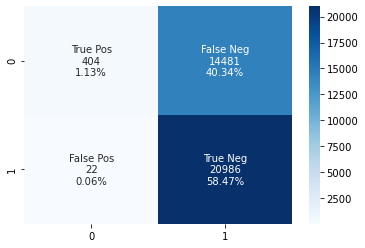

In [53]:
cf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

The accuracy and f1 score of Naive bayes model is almost same as Dummy model performance. Hence, the Naive bayes model is not performing well for this dataset and not considersing for Ensemble stacking method.

# Model 1: KNN

The prediction of a crowdfunding campaign involves two possible outcomes, success and failure,
and as such, the prediction task is regarded as binary classification.KNN algorithm is a
widely used classifier with high performance on a wide range of real datasets.
Principally, KNN works
by comparing distance of each data instance in the testing set to all data instances in the training set.
Then, for each data instance in the testing set, the K nearest neighbors are examined. The class labels of
the majority from the K nearest neighbors is thus taken to be the predicted class label of the respective
data instance in the testing set The predicted class of each data instance in the testing set is then
compared to its real class label (its hidden class values). The prediction accuracy is then computed by
considering the number of times the model is right in prediction. Here we tried different n_neighbour values but the best result was obtained when n is 19 and weights as uniform with minkowski distance.

In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn_grid = [    
    {'n_neighbors' : [3,5,7,9,11,13,15,17,19],
    'weights' : ['uniform','distance']
    }
]
knn = KNeighborsClassifier()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = knn_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions=[{'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                         17, 19],
                                         'weights': ['uniform', 'distance']}],
                   random_state=42, verbose=2)

In [55]:
knn_random.best_params_

{'weights': 'uniform', 'n_neighbors': 19}

In [56]:
knn_csf = knn_random.best_estimator_
knn_csf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=19)

In [57]:
y_pred = knn_csf.predict(X_test)
knn_score = knn_csf.score(X_test,y_test)
knn_f1 = f1_score(y_test, y_pred, average = 'weighted')

In [58]:
print("\nClassification report:")
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
cf_matrix


Classification report:
              precision    recall  f1-score   support

           0       0.46      0.29      0.36     14885
           1       0.60      0.76      0.67     21008

    accuracy                           0.57     35893
   macro avg       0.53      0.53      0.51     35893
weighted avg       0.54      0.57      0.54     35893



array([[ 4351, 10534],
       [ 5070, 15938]], dtype=int64)

<AxesSubplot:>

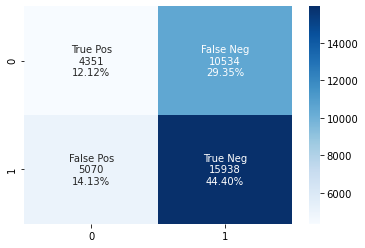

In [59]:
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Model 2: Logistic Regression

Logistic Regression is generally used for classification purposes. Unlike Linear Regression, the dependent variable can take a limited number of values only i.e, the dependent variable is categorical. When the number of possible outcomes is only two it is called Binary Logistic Regression.
In our project we have success and failure as target or dependent variable.

In [60]:
from sklearn.linear_model import LogisticRegression
log_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]
logreg = LogisticRegression()
logistic_random = RandomizedSearchCV(estimator = logreg, param_distributions = log_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
logistic_random.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  4.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.1min finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=25, n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'sag',
                                                    'saga']}],
                   random_state=42, verbose=2)

In [61]:
logistic_random.best_params_

{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 2500,
 'C': 3792.690190732246}

In [62]:
logreg = logistic_random.best_estimator_

In [63]:
y_pred = logreg.predict(X_test)
log_score = logreg.score(X_test,y_test)
log_f1 = f1_score(y_test, y_pred, average = 'weighted')

In [64]:
print("\nClassification report:")
print(classification_report(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

           0       0.61      0.35      0.44     14885
           1       0.65      0.84      0.73     21008

    accuracy                           0.64     35893
   macro avg       0.63      0.60      0.59     35893
weighted avg       0.63      0.64      0.61     35893



<AxesSubplot:>

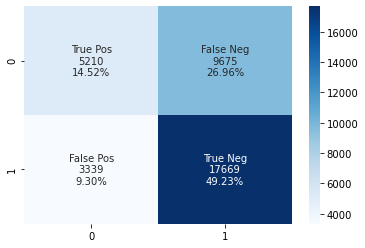

In [65]:
cf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

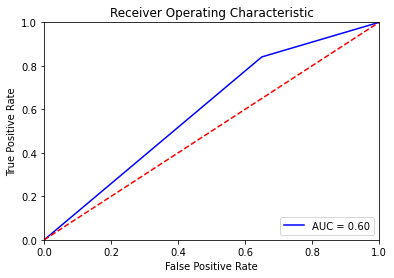

In [66]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Model 3: Random Forest Classifier





The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree. In this project we are able to get 71% of accuracy.

In [67]:
from sklearn.ensemble import RandomForestClassifier

# parameters
random_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200]
}
# based model
rf = RandomForestClassifier()
# Random search model
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [80, 90, 100, 110],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [68]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_depth': 80,
 'bootstrap': True}

In [69]:
classifier = rf_random.best_estimator_

In [70]:
# Predicting the test set results
y_pred = classifier.predict(X_test)
rf_score = classifier.score(X_test,y_test)
rf_f1 = f1_score(y_test, y_pred, average = 'weighted')

In [71]:
print("\nClassification report:")
print(classification_report(y_test, y_pred))
f1_score(y_test,y_pred, average = 'weighted')


Classification report:
              precision    recall  f1-score   support

           0       0.68      0.57      0.62     14885
           1       0.73      0.81      0.77     21008

    accuracy                           0.71     35893
   macro avg       0.70      0.69      0.69     35893
weighted avg       0.71      0.71      0.71     35893



0.7050505646833038

<AxesSubplot:>

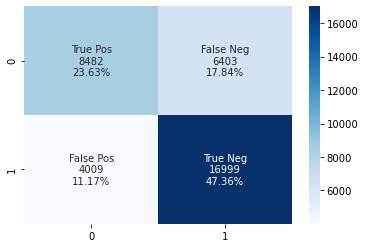

In [72]:
cf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Model 4: Ensemble stacking classifier

Ensemble Stacking Classifier uses a meta classifier to make predictions by combining the predictions of more than one heterogeneous machine learning algorithms. The base classifiers models will fit on the entire training dataset to make predictions and the meta classifier combines the predictions from the base classifier for the best prediction. Overall, the meta classifier will reduce generalization errors.

For this project, Logistic regression, Random Forest and KNN algorithms are considered as the base classifiers and Logistic regression is taken as meta classifier to make the final prediction from the results of the base classifiers.
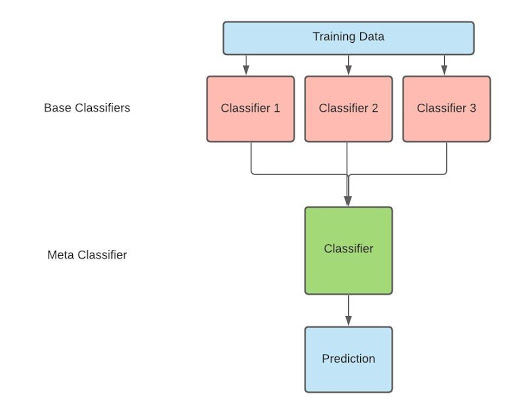

In [73]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# define the base models
level0 = list()
level0.append(('lr', logistic_random.best_estimator_))
level0.append(('knn', knn_random.best_estimator_))
level0.append(('RF', rf_random.best_estimator_))
# level0.append(('bayes', GaussianNB()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X_train, y_train)
# predictions on X_test
yhat = model.predict(X_test)

In [74]:
stacking_score = model.score(X_test,y_test)
stacking_f1 = f1_score(y_test, y_pred, average = 'weighted')

In [75]:
print("\nClassification report:")
print(classification_report(y_test, yhat))


Classification report:
              precision    recall  f1-score   support

           0       0.66      0.59      0.63     14885
           1       0.73      0.79      0.76     21008

    accuracy                           0.71     35893
   macro avg       0.70      0.69      0.69     35893
weighted avg       0.70      0.71      0.70     35893



<AxesSubplot:>

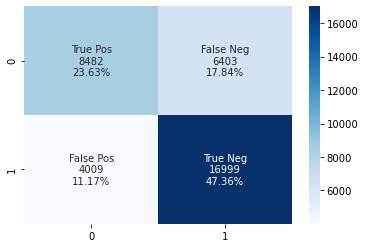

In [76]:
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Comparing Model performances



Accuracy for different *models*

<AxesSubplot:xlabel='Model'>

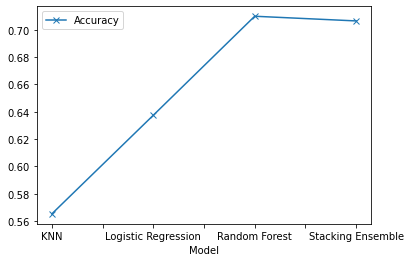

In [77]:
d = {'Model':['KNN','Logistic Regression','Random Forest','Stacking Ensemble'],'Accuracy':[knn_score,log_score,rf_score,stacking_score]}

agg_scores = pd.DataFrame(data = d)
agg_scores.plot(x='Model',y='Accuracy',kind='line', marker='x')

F1-Score for different models

<AxesSubplot:xlabel='Model'>

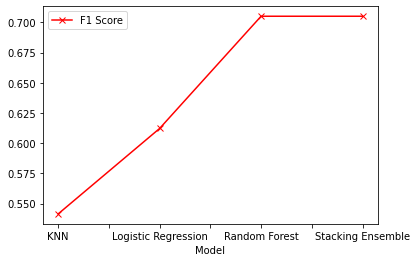

In [78]:
d1 = {'Model':['KNN','Logistic Regression','Random Forest','Stacking Ensemble'],'F1 Score':[knn_f1,log_f1,rf_f1,stacking_f1]}

agg_scores = pd.DataFrame(data = d1)
agg_scores.plot(x='Model',y='F1 Score',kind='line', marker='x',color = 'red')

### **Result:**

For this project we have tried using different traditional machine learning algorithms like KNN, Logistic regression, Random forest and we also tried ensemble methods like stacking. Overall, we have a highest accuracy for both Random Forest and Stacking ensemble technique which is almost 71% and f1 score of nearly 70%. 

Hence, for the final deployment of the model we are considering the Random Forest even though stacking ensemble have the almost same accuracy because Random forest is less complex and will take less computation power when compared to Stacking ensemble technique.

### **Impact after resolution & future work**

We ultimately determined that using ensemble models works much better than individual machine learning models as we observed when we tested the performance of various models against each other. Training and testing the model takes a lot of computation time since ensemble models and bagging runs various models parallely. However, we are able to obtain a high accuracy so it is worth the long run-time.


### References
- Michael D Greenberg, Bryan Pardo, Karthic Hariharan, and Elizabeth Gerber. Crowdfunding support tools: predicting success & failure. In CHI’13 Extended Abstracts on Human Factors in Computing Systems, pages 1815–1820. ACM, 2013. 
- Chenchen Pen et.al, Predicting the Success of Crowdfunding.
